# Association Rule: Heuristic Approach

#### Loading necessary libraries

In [240]:
import pandas as pd
import os
import string
from nltk.corpus import stopwords
from collections import Counter 
from itertools import combinations

## 1. Reading data

### 1.1 Reading features for each of the paragraphs - Entities and Sentiments

In [241]:
#text_feat = pd.read_csv("text_features.csv",encoding='ISO-8859-1')

In [242]:
#text_feat.head()

### 1.2 Reading the actual content of each paragraph

In [243]:
#textdatanew = pd.read_csv("textdatanew.csv",encoding='ISO-8859-1')
textdatanew.head()

,CollectionID,BiographyID,ParagraphNo,ParagraphText,Word_split
0,a001,bio04,1,"A FRENCH philosopher, moralizing on the great ...","[A, FRENCH, philosopher, moralizing, on, the, ..."
1,a001,bio04,2,Cleopatra was joint heir to the throne of Egyp...,"[Cleopatra, was, joint, heir, to, the, throne,..."
2,a001,bio04,3,Cleopatra might have responded with a brillian...,"[Cleopatra, might, have, responded, with, a, b..."
3,a001,bio04,4,Caesar was then above fifty years of age. His ...,"[Caesar, was, then, above, fifty, years, of, a..."
4,a001,bio04,5,For three years Cleopatra reigned with little ...,"[For, three, years, Cleopatra, reigned, with, ..."


## 2. Analyzing and Processing data

Splitting the paragraph to have each word in a single record

In [8]:
textdatanew['Word_split'] = textdatanew.ParagraphText.apply(lambda x: ''.join(s for s in x if s not in string.punctuation).split(" "))

In [12]:
textdatanew.head()

,CollectionID,BiographyID,ParagraphNo,ParagraphText,Word_split
0,a001,bio04,1,"A FRENCH philosopher, moralizing on the great ...","[A, FRENCH, philosopher, moralizing, on, the, ..."
1,a001,bio04,2,Cleopatra was joint heir to the throne of Egyp...,"[Cleopatra, was, joint, heir, to, the, throne,..."
2,a001,bio04,3,Cleopatra might have responded with a brillian...,"[Cleopatra, might, have, responded, with, a, b..."
3,a001,bio04,4,Caesar was then above fifty years of age. His ...,"[Caesar, was, then, above, fifty, years, of, a..."
4,a001,bio04,5,For three years Cleopatra reigned with little ...,"[For, three, years, Cleopatra, reigned, with, ..."


In [10]:
text_stack = textdatanew.apply(lambda x: pd.Series(x['Word_split']), axis=1).stack().reset_index(level=1, drop=True)

In [11]:
text_stack.name = 'Word_splits'
textdatanew2 = textdatanew.drop(['ParagraphText','Word_split'], axis=1).join(text_stack)
textdatanew2['Word_splits'] = pd.Series(textdatanew2['Word_splits'], dtype=object)
#textdatanew2

Creating a Unique identifier for each of the paragraph

In [13]:
textdatanew2['Unique_id'] = textdatanew2.CollectionID+"_"+textdatanew2.BiographyID+"_"+textdatanew2.ParagraphNo.apply(str)

In [33]:
### Removing extra columns
Text_Para = textdatanew2.drop(['CollectionID','BiographyID','ParagraphNo'], axis = 1).drop_duplicates()

In [86]:
Text_Para.shape

(1176797, 3)

In [135]:
word_counts = Counter(Text_Para.Word_splits.apply(lambda x: x.lower()))
most_common_words = [each[0] for each in word_counts.most_common(100)]
#word_counts.most_common(100)

In [57]:
Text_Para['Word_freq'] = Text_Para.Word_splits.apply(lambda x: word_counts[x.lower()])

#### Distribution of words greater than minimum and less than maximum threshold

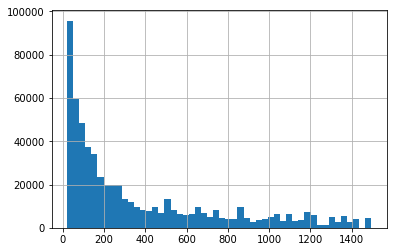

In [82]:
p = Text_Para.Word_freq[(Text_Para.Word_freq>20) & (Text_Para.Word_freq < 1500)].hist(bins = 50)

In [131]:
Text_Para.tail()

,Word_splits,Unique_id,Word_freq
16636,still,p091C_bio19_103,1181
16636,bloomed,p091C_bio19_103,8
16636,for,p091C_bio19_103,8790
16636,Lola,p091C_bio19_103,512
16636,Montez,p091C_bio19_103,186


In [142]:
#### Upper Threshold determined after selecting top 100 values
#Text_para_final = Text_Para[(Text_Para.Word_freq > 20)  & (Text_Para.Word_freq < 1500)]

,Word_splits,Unique_id,Word_freq
0,FRENCH,a001_bio04_1,396
0,influence,a001_bio04_1,410
0,matters,a001_bio04_1,135
0,remarked,a001_bio04_1,99
0,end,a001_bio04_1,663


In [219]:
# Generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    
    # For each order, generate a list of items in that order
    for order_id, order_object in order_item.groupby('Unique_id')['Words_clean']:
        item_list = order_object.values
        # For each item list, generate item pairs, one at a time
        for item_pair in combinations(item_list, 2):
            yield item_pair

In [201]:
Text_para_final['Words_clean'] = Text_para_final.Word_splits.apply(lambda x: x.lower())

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [246]:
# Counter iterates through the item pairs returned by our generator and keeps a tally of their occurrence
word_pairs = Counter(get_item_pairs(Text_para_final))

In [249]:
word_pairs

Counter({('french', 'influence'): 9,
         ('french', 'matters'): 3,
         ('french', 'remarked'): 5,
         ('french', 'end'): 20,
         ('french', 'cleopatras'): 1,
         ('french', 'nose'): 4,
         ('french', 'changed'): 5,
         ('french', 'history'): 17,
         ('french', 'rome'): 3,
         ('french', 'egypt'): 1,
         ('french', 'beauty'): 13,
         ('french', 'wit'): 3,
         ('french', 'audacity'): 2,
         ('french', 'greatest'): 4,
         ('french', 'generals'): 3,
         ('french', 'ever'): 28,
         ('french', 'sent'): 19,
         ('french', 'until'): 14,
         ('french', 'third'): 5,
         ('french', 'remained'): 8,
         ('french', 'charms'): 2,
         ('french', 'displayed'): 3,
         ('french', 'abandon'): 3,
         ('french', 'effort'): 4,
         ('french', 'rule'): 2,
         ('french', 'world'): 16,
         ('french', 'seek'): 3,
         ('french', 'refuge'): 6,
         ('french', 'death'): 27,
     

In [251]:
Text_para_final.Words_clean.isin

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [str]

#### Reducing the vocabulary size to avoid memory error

In [74]:
### Checking the vocabulary size of the data
len(Text_Para.Word_splits.unique())

61994

Finding high frequency and low frequency words

In [100]:
high_freq_threshold = 5000
low_freq_threshold = 10

In [102]:
high_freq_words = Text_Para.Word_splits.value_counts()[Text_Para.Word_splits.value_counts() > top_freq_threshold].index
low_freq_words = Text_Para.Word_splits.value_counts()[Text_Para.Word_splits.value_counts() < low_freq_threshold].index

In [138]:
### Clean stopwords
clean_stop_words = ''.join([each for each in 'ZZ'.join(stopwords.words('english')) if each not in string.punctuation]).split("ZZ")

In [139]:
clean_stop_words.extend(list(low_freq_words))
clean_stop_words.extend(list(high_freq_words))

In [177]:
words_to_remove = list(set(clean_stop_words))
words_to_remove_upper = [each.split()[0].upper() for each in words_to_remove]